In [1]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random
import yfinance as yf

# For RL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Plot styles
plt.style.use('seaborn-darkgrid')

<ipython-input-1-0664aad5d1b5>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


[*********************100%***********************]  5 of 5 completed


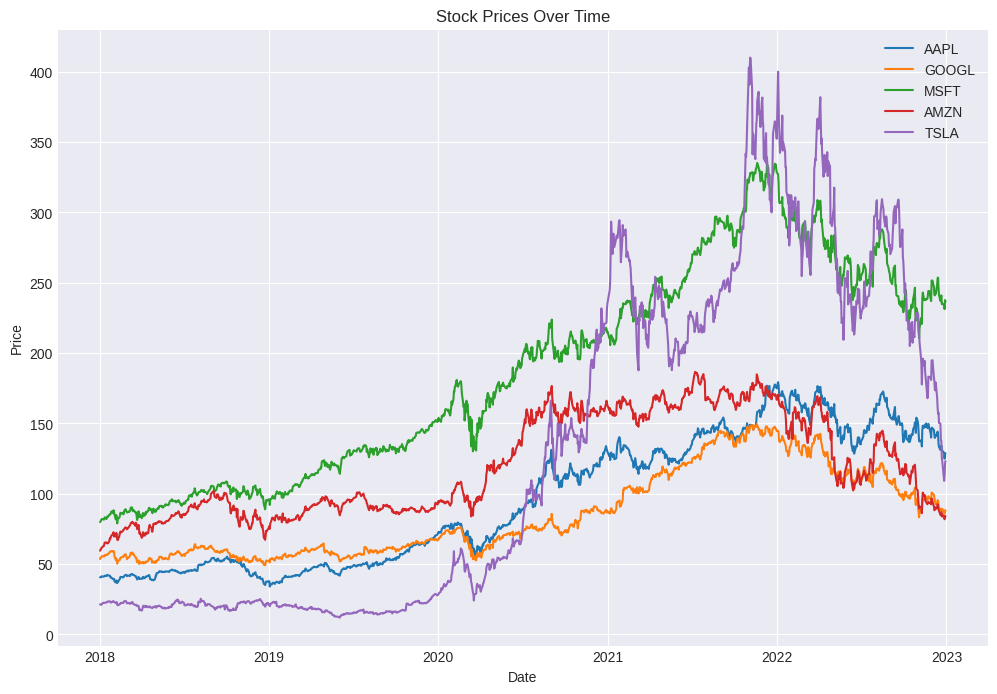

In [2]:
# List of stock tickers
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']

# Download data from Yahoo Finance
data = yf.download(tickers, start='2018-01-01', end='2023-01-01')['Adj Close']

# Visualize stock prices
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(data[ticker], label=ticker)
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [3]:
# Portfolio Environment
class PortfolioEnv:
    def __init__(self, stock_data, initial_balance=10000):
        self.stock_data = stock_data
        self.n_assets = stock_data.shape[1]
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.current_step = 0
        self.positions = np.zeros(self.n_assets)
        return self._get_observation()

    def _get_observation(self):
        obs = np.concatenate((self.stock_data.iloc[self.current_step].values, self.positions, [self.balance]))
        return obs

    def step(self, action):
        current_prices = self.stock_data.iloc[self.current_step].values
        prev_positions = self.positions.copy()

        # Action is the percentage of portfolio allocated to each stock (softmax output)
        action = np.array(action) / np.sum(action)  # Normalize action to be a valid probability distribution
        self.positions = action * self.balance / current_prices

        next_prices = self.stock_data.iloc[self.current_step + 1].values
        portfolio_value = np.dot(self.positions, next_prices)
        reward = portfolio_value - np.dot(prev_positions, current_prices)

        # Update balance
        self.balance += reward
        self.current_step += 1

        done = self.current_step >= len(self.stock_data) - 2
        obs = self._get_observation()

        return obs, reward, done, {}

    def render(self):
        print(f"Step: {self.current_step}, Balance: {self.balance}")

In [4]:
# DQN Agent
class DQNAgent:
    def __init__(self, n_assets, state_size):
        self.n_assets = n_assets
        self.state_size = state_size
        self.action_size = n_assets
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='softmax'))  # Softmax for probability distribution
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.rand(self.n_assets)  # Random action
        act_values = self.model.predict(state)
        return act_values[0]  # Best action

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][np.argmax(action)] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
# Initialize environment and agent
env = PortfolioEnv(stock_data=data)
state_size = env.n_assets * 2 + 1
agent = DQNAgent(n_assets=env.n_assets, state_size=state_size)

# Training parameters
n_episodes = 5
n_timesteps = 50
batch_size = 16

# Initialize total rewards list
total_rewards = []

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Training loop
for episode in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    for t in range(n_timesteps):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if done:
            print(f"Episode: {episode+1}/{n_episodes}, Reward: {total_reward}")
            break

    total_rewards.append(total_reward)

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

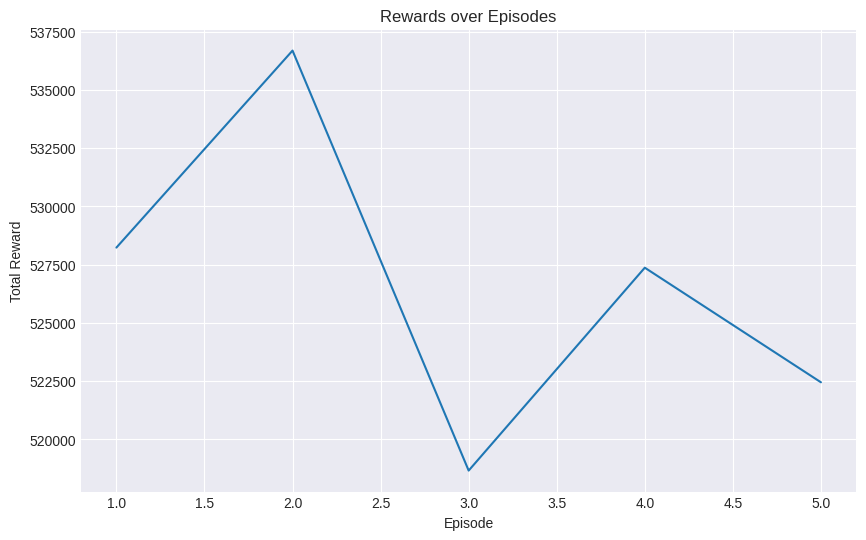

In [7]:
# Plotting the reward for each episode
plt.figure(figsize=(10, 6))
plt.plot([i for i in range(1, n_episodes+1)], total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()

Average Return: -0.12%
Sharpe Ratio: -2.13


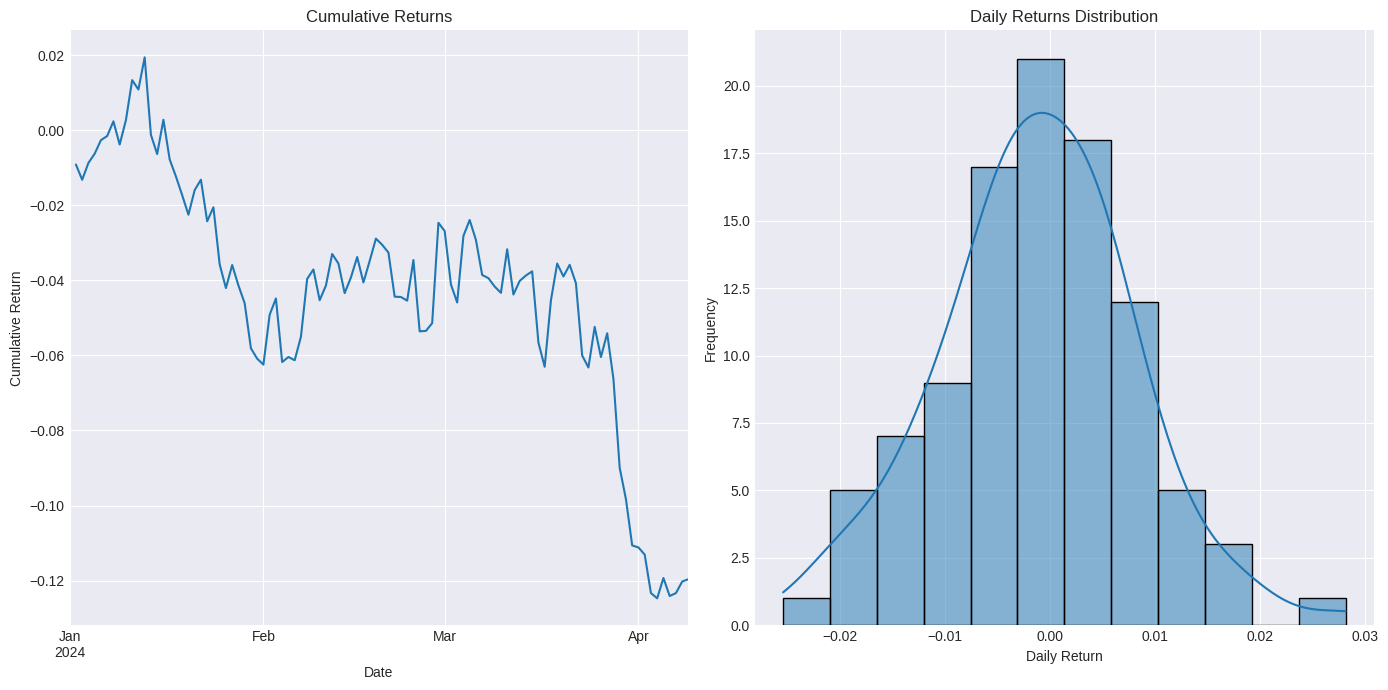

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics(df):
    # Calculate daily returns
    df['daily_return'] = df['portfolio_value'].pct_change()
    # Calculate cumulative returns
    df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1
    # Calculate average return
    avg_return = df['daily_return'].mean()
    # Calculate Sharpe ratio (assuming risk-free rate is 0)
    sharpe_ratio = df['daily_return'].mean() / df['daily_return'].std() * np.sqrt(252)

    return avg_return, sharpe_ratio, df

def plot_performance(df):
    plt.figure(figsize=(14, 7))

    # Plot cumulative returns
    plt.subplot(1, 2, 1)
    df['cumulative_return'].plot()
    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')

    # Plot daily returns distribution
    plt.subplot(1, 2, 2)
    sns.histplot(df['daily_return'].dropna(), kde=True)
    plt.title('Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage
# Create a sample DataFrame
data = {
    'date': pd.date_range(start='2024-01-01', periods=100, freq='D'),
    'portfolio_value': (1000 + (np.random.randn(100).cumsum() * 10))  # Example data
}
trading_results_df = pd.DataFrame(data)
trading_results_df.set_index('date', inplace=True)

# Calculate metrics and plot
avg_return, sharpe_ratio, df_with_metrics = calculate_metrics(trading_results_df)
print(f"Average Return: {avg_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot performance
plot_performance(df_with_metrics)


Average Return: 0.13%
Sharpe Ratio: 2.52


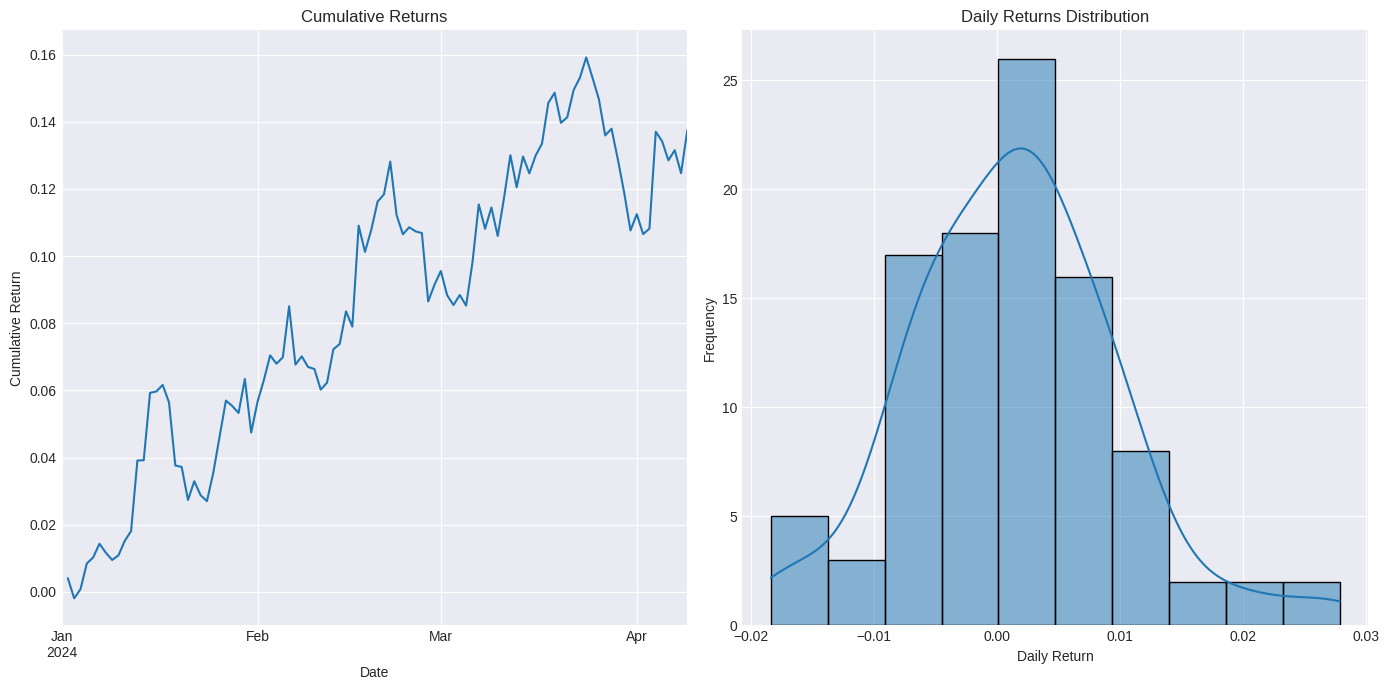

Benchmark Average Return: -0.03%
Benchmark Sharpe Ratio: -0.92


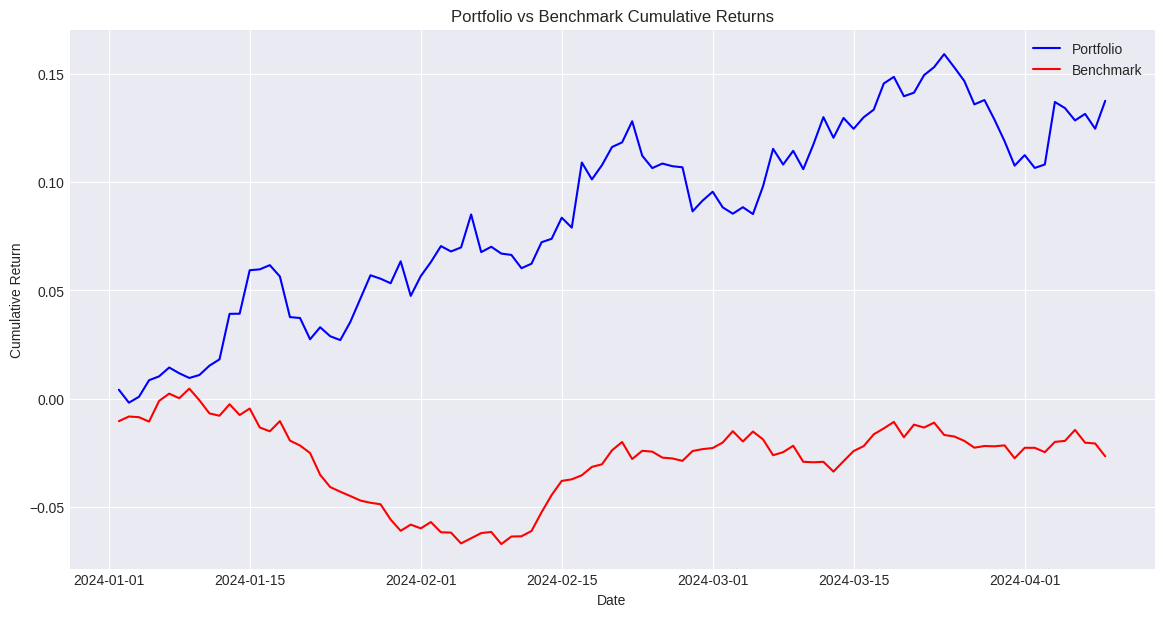

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics(df):
    df['daily_return'] = df['portfolio_value'].pct_change()
    df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1
    avg_return = df['daily_return'].mean()
    sharpe_ratio = df['daily_return'].mean() / df['daily_return'].std() * np.sqrt(252)

    return avg_return, sharpe_ratio, df

def plot_performance(df):
    plt.figure(figsize=(14, 7))

    # Plot cumulative returns
    plt.subplot(1, 2, 1)
    df['cumulative_return'].plot()
    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')

    # Plot daily returns distribution
    plt.subplot(1, 2, 2)
    sns.histplot(df['daily_return'].dropna(), kde=True)
    plt.title('Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def compare_benchmarks(df, benchmark_df):
    plt.figure(figsize=(14, 7))

    # Plot cumulative returns for portfolio and benchmark
    plt.plot(df.index, df['cumulative_return'], label='Portfolio', color='blue')
    plt.plot(benchmark_df.index, benchmark_df['cumulative_return'], label='Benchmark', color='red')
    plt.title('Portfolio vs Benchmark Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()

# Example usage
# Create a sample DataFrame for the portfolio
data = {
    'date': pd.date_range(start='2024-01-01', periods=100, freq='D'),
    'portfolio_value': (1000 + (np.random.randn(100).cumsum() * 10))  # Example data
}
trading_results_df = pd.DataFrame(data)
trading_results_df.set_index('date', inplace=True)

# Calculate metrics and plot
avg_return, sharpe_ratio, df_with_metrics = calculate_metrics(trading_results_df)
print(f"Average Return: {avg_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot performance
plot_performance(df_with_metrics)

# For benchmarking
benchmark_data = {
    'date': pd.date_range(start='2024-01-01', periods=100, freq='D'),
    'portfolio_value': (1000 + (np.random.randn(100).cumsum() * 5))  # Example benchmark data
}
benchmark_df = pd.DataFrame(benchmark_data)
benchmark_df.set_index('date', inplace=True)
benchmark_avg_return, benchmark_sharpe_ratio, benchmark_df_with_metrics = calculate_metrics(benchmark_df)
print(f"Benchmark Average Return: {benchmark_avg_return:.2%}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")

# Compare with benchmark
compare_benchmarks(df_with_metrics, benchmark_df_with_metrics)
